We try to find a mapping between node2vec and the angles in hyperbolic space, it is shown that in high dimensions cosine and euclidean distances when used to measure distance perform identically in community detection tasks. This indicates that the lengths don't play a significant role in that anyways. In that case can we map them into S1 space where we only require angular gaps to detect communities.

[Angular Synchronization by Eigenvectors and Semidefinite Programming
](https://arxiv.org/abs/0905.3174)
seems to have a way of providing a mapping theta 1, N using the offsets theta i - theta j, which we will provide from the cosine similarities of two vectors from node2vec in a high dimensional space, and get the angles theta i to theta j which we will use as angular coordinates in S1 space.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

def angular_synchronization(n, measurements):
    """
    Compute the angles on S^1 via angular synchronization.
    
    Parameters:
    - n: int, number of nodes.
    - measurements: list of tuples (i, j, delta_theta) indicating that
      measurement from node i to node j is delta_theta (in radians).
      
    Returns:
    - theta_est: numpy array of estimated angles for each node.
    """
    # Build lists for sparse matrix construction
    row = []
    col = []
    data = []
    
    # For each measurement, add H_{ij} = exp(i * delta_theta)
    for i, j, delta in measurements:
        row.append(i)
        col.append(j)
        data.append(np.exp(1j * delta))
        
        # Optionally, if the measurements are symmetric, you can add the conjugate
        # measurement as well:
        row.append(j)
        col.append(i)
        data.append(np.exp(-1j * delta))
    
    # Construct sparse matrix H
    H = coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    
    # Compute the leading eigenvector
    # Note: since H is generally non-Hermitian if measurements are inconsistent,
    # we may want to compute eigenvalues of H (or H + H^*.T for symmetry).
    # Here, we assume H is approximately Hermitian.
    vals, vecs = eigs(H, k=1, which='LM')
    v = vecs[:, 0]
    
    # Normalize the eigenvector (not strictly necessary)
    v = v / np.abs(v)
    
    # Extract angles
    theta_est = np.angle(v)
    
    return theta_est

import numpy as np

def align_angles(theta_true, theta_est):
    """
    Align estimated angles to the true angles by finding the optimal global offset.
    
    Parameters:
      theta_true : numpy.ndarray
          The ground truth angles (in radians).
      theta_est : numpy.ndarray
          The estimated angles (in radians).
    
    Returns:
      theta_est_aligned : numpy.ndarray
          The estimated angles shifted by the optimal offset.
      offset : float
          The computed optimal offset.
    """
    # Compute the differences between true and estimated angles.
    # Because the angles are periodic, we compute these differences in the complex plane.
    differences = np.exp(1j * (theta_true - theta_est))
    
    # The optimal global offset is the phase (angle) of the mean of these differences.
    offset = np.angle(np.mean(differences))
    
    # Align the estimated angles by adding the offset and wrapping them into [0, 2*pi)
    theta_est_aligned = (theta_est + offset) % (2 * np.pi)
    return theta_est_aligned, offset

Optimal offset: -1.045646557382002


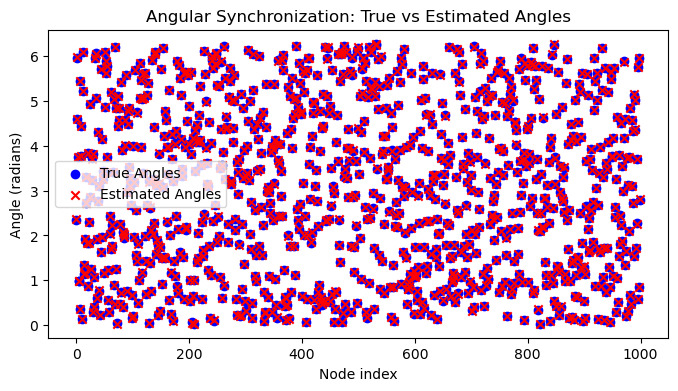

In [3]:
# Example usage:

# Suppose we have 5 nodes. Define some true angles.
n_nodes = 1000
np.random.seed(42)
true_angles = np.random.uniform(0, 2*np.pi, n_nodes)
#print("True angles:", true_angles)

# Create synthetic measurements: for a pair (i,j), we measure
# delta = true_angles[i] - true_angles[j] plus some noise.
measurements = []
noise_level = 0.1  # noise standard deviation in radians
for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        # True difference modulo 2pi
        delta_true = np.angle(np.exp(1j * true_angles[i]) / np.exp(1j * true_angles[j]))
        # Add noise
        delta_noisy = delta_true + np.random.normal(0, noise_level)
        # Wrap the angle between -pi and pi
        delta_noisy = np.arctan2(np.sin(delta_noisy), np.cos(delta_noisy))
        measurements.append((i, j, delta_noisy))

# Run angular synchronization
theta_est = angular_synchronization(n_nodes, measurements)
#print("Estimated angles:", theta_est)

theta_aligned, offset = align_angles(true_angles, theta_est)
print("Optimal offset:", offset)
#print("Aligned estimated angles:", theta_aligned)
 
plt.figure(figsize=(8,4))
plt.scatter(range(n_nodes), true_angles, c='blue', label='True Angles')
plt.scatter(range(n_nodes), theta_aligned, c='red', marker='x', label='Estimated Angles')
plt.xlabel('Node index')
plt.ylabel('Angle (radians)')
plt.legend()
plt.title('Angular Synchronization: True vs Estimated Angles')
plt.show()

In [ ]:
# We want to get the hyperbolci c